### Import library

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### Load and Prepare the Data

In [17]:
df = pd.read_csv("../data/raw_analyst_ratings/raw_analyst_ratings.csv")

In [3]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [12]:
df.tail()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,year,month,day,day_of_week,sentiment,hour,domain
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 00:00:00+00:00,ZX,38,2011,8,29,Monday,Positive,0,Monica Gerson
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 00:00:00+00:00,ZX,52,2011,6,22,Wednesday,Positive,0,Benjamin Lee
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 00:00:00+00:00,ZX,56,2011,6,21,Tuesday,Neutral,0,BenzingaStaffL
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 00:00:00+00:00,ZX,54,2011,6,21,Tuesday,Neutral,0,Joe Young
1407327,1413848,China Zenix Auto International Opens For Tradi...,https://www.benzinga.com/news/ipos/11/05/10789...,Allie Wickman,2011-05-12 00:00:00+00:00,ZX,81,2011,5,12,Thursday,Neutral,0,Allie Wickman


In [4]:
df.info

<bound method DataFrame.info of          Unnamed: 0                                           headline  \
0                 0            Stocks That Hit 52-Week Highs On Friday   
1                 1         Stocks That Hit 52-Week Highs On Wednesday   
2                 2                      71 Biggest Movers From Friday   
3                 3       46 Stocks Moving In Friday's Mid-Day Session   
4                 4  B of A Securities Maintains Neutral on Agilent...   
...             ...                                                ...   
1407323     1413844             Top Narrow Based Indexes For August 29   
1407324     1413845  Recap: Wednesday's Top Percentage Gainers and ...   
1407325     1413846  UPDATE: Oppenheimer Color on China Zenix Auto ...   
1407326     1413847  Oppenheimer Initiates China Zenix At Outperfor...   
1407327     1413848  China Zenix Auto International Opens For Tradi...   

                                                       url          publisher  

In [5]:
#find missing value
df.isnull().sum()

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

In [19]:
#find dupplicats
df.duplicated().sum()

0

## Descriptive Statistics:

In [6]:
df.columns
# Calculate the length of each headline
df['headline_length'] = df['headline'].apply(len)
print(df['headline_length'])
# Descriptive statistics for headline lengths
headline_stats = df['headline_length'].describe()
# 2. Count the Number of Articles per Publisher
articles_per_publisher = df['publisher'].value_counts()
# Display the results
print("Headline Length Statistics:\n", headline_stats)
print("\nArticles per Publisher:\n", articles_per_publisher)

0          39
1          42
2          29
3          44
4          87
           ..
1407323    38
1407324    52
1407325    56
1407326    54
1407327    81
Name: headline_length, Length: 1407328, dtype: int64
Headline Length Statistics:
 count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

Articles per Publisher:
 publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


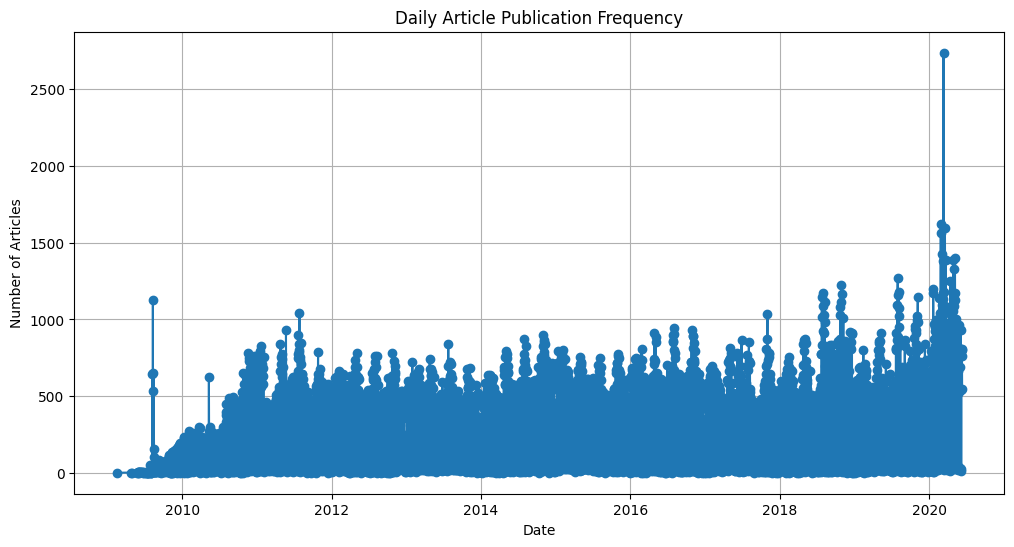

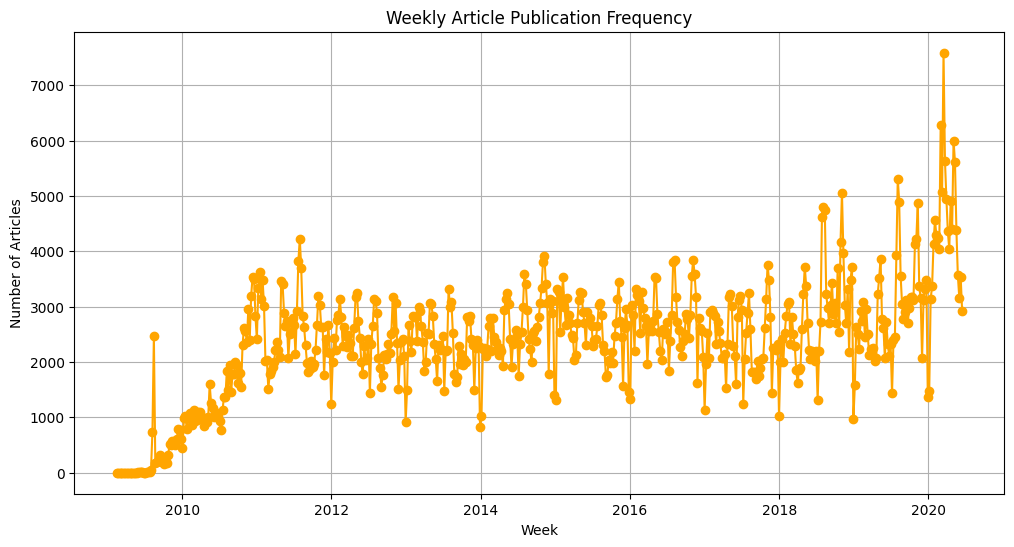

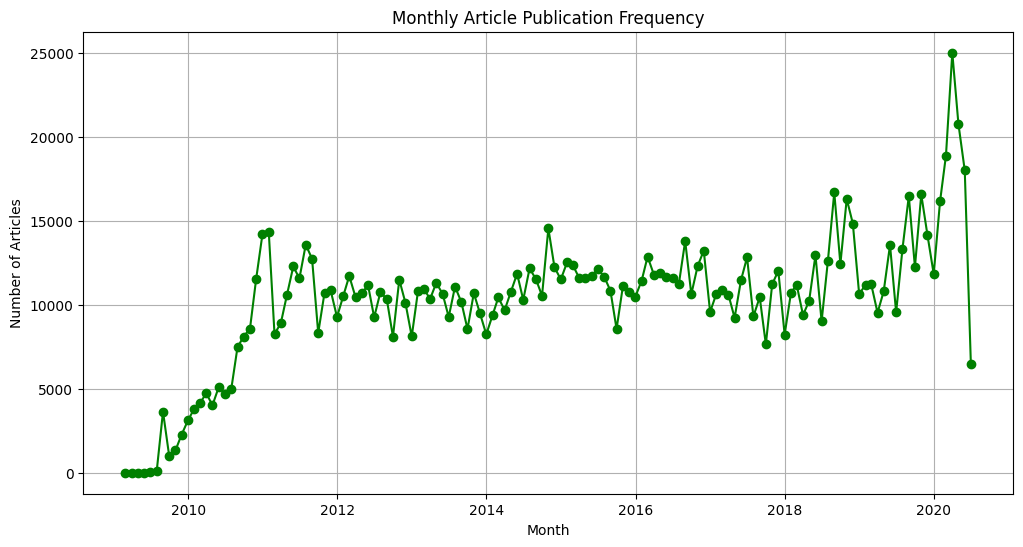

In [7]:
#Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'],format="ISO8601", utc=True)

# 2. Extract relevant time information
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()

# 3. Group and aggregate data by date
daily_counts = df.groupby(df['date'].dt.date).size()
weekly_counts = df.groupby(pd.Grouper(key='date', freq='W')).size()
monthly_counts = df.groupby(pd.Grouper(key='date', freq='M')).size()

# 4. Visualize the trends

# Plot daily counts
plt.figure(figsize=(12, 6))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.title('Daily Article Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

# Plot weekly counts
plt.figure(figsize=(12, 6))
plt.plot(weekly_counts.index, weekly_counts.values, marker='o', color='orange')
plt.title('Weekly Article Publication Frequency')
plt.xlabel('Week')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

# Plot monthly counts
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o', color='green')
plt.title('Monthly Article Publication Frequency')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

### Text Analysis(Sentiment analysis & Topic Modeling):

In [8]:
# 1.1 Perform Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    # Classify sentiment as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'
df['sentiment'] = df['headline'].apply(get_sentiment)


In [9]:
# 1.2 Topic Modeling using LDA
# Vectorize the headlines
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['headline'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

# Display the top words per topic
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

n_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, n_top_words)

# Display results
print(df[['headline', 'sentiment']])

Topic #1:
market update stocks announces mid session new moving day shares
Topic #2:
vs est eps reports sales pt raises maintains upgrades downgrades
Topic #3:
shares stocks earnings trading week benzinga stock 52 companies scheduled
                                                  headline sentiment
0                  Stocks That Hit 52-Week Highs On Friday   Neutral
1               Stocks That Hit 52-Week Highs On Wednesday   Neutral
2                            71 Biggest Movers From Friday   Neutral
3             46 Stocks Moving In Friday's Mid-Day Session   Neutral
4        B of A Securities Maintains Neutral on Agilent...   Neutral
...                                                    ...       ...
1407323             Top Narrow Based Indexes For August 29  Positive
1407324  Recap: Wednesday's Top Percentage Gainers and ...  Positive
1407325  UPDATE: Oppenheimer Color on China Zenix Auto ...   Neutral
1407326  Oppenheimer Initiates China Zenix At Outperfor...   Neutral
1407327

### Time Series Analysis

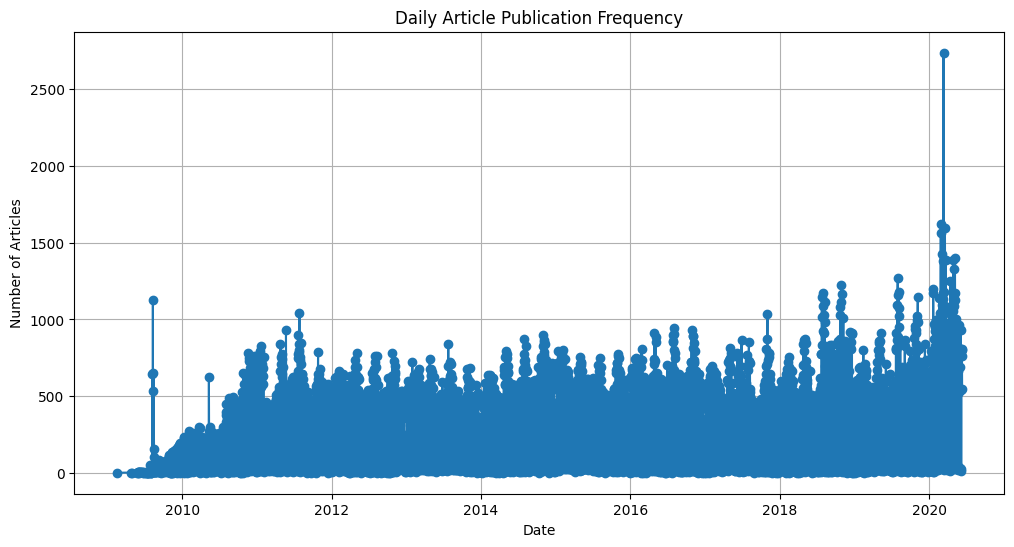

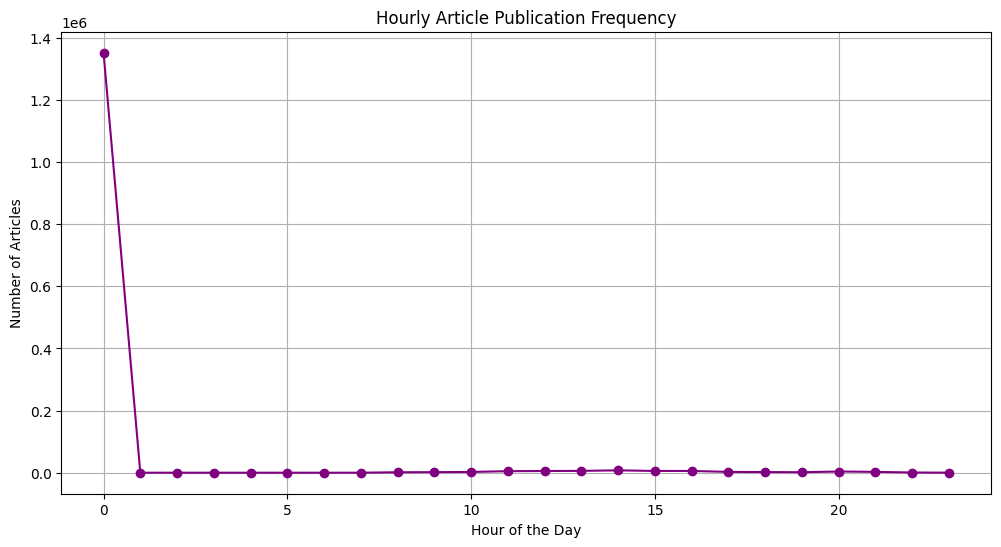

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Convert the 'date' column to datetime if not already done
df['date'] = pd.to_datetime(df['date'],format="ISO8601", utc=True)

# 2.1 Analyze Publication Frequency Over Time
daily_counts = df.groupby(df['date'].dt.date).size()

# Plot daily counts
plt.figure(figsize=(12, 6))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.title('Daily Article Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

# 2.2 Analyze Publishing Times (Hour of the Day)
df['hour'] = df['date'].dt.hour
hourly_counts = df.groupby(df['hour']).size()

# Plot hourly counts
plt.figure(figsize=(12, 6))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o', color='purple')
plt.title('Hourly Article Publication Frequency')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()


### 	Publisher Analysis

In [11]:
# 3.1 Count the Number of Articles per Publisher
articles_per_publisher = df['publisher'].value_counts()

# Display the top publishers
print("Top Publishers:\n", articles_per_publisher)

# 3.2 Extract Unique Domains (if emails are used as publisher names)
# Assuming 'publisher' column contains email addresses
df['domain'] = df['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else x)
domains_count = df['domain'].value_counts()

# Display the top domains
print("\nTop Domains:\n", domains_count)


Top Publishers:
 publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64

Top Domains:
 domain
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
Mark Davis                1
janaviktoria              1
Kiana Danial              1
giovannimola              1
Jeremie Capron            1
Name: count, Length: 1024, dtype: int64
